# GroMore base model domain
## Model Description before GroMore proposal 
This is a steady state box model with recharge and ET. An additional layer was also added to the model.

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 1000 m
- dz = varied 
- three layers

#### Topography
- Top layer elevation given in csv file
- Middle layer is flat and 5m thick
- Bottom layer (Layer 3) is flat and 40m thick

#### Subsurface Properties: 
- Porosity = 0.1
- Specific yield = 0.1
- Storage coefficient=0.0001 
- Homogeneous in each layer
##### Layers
 - Layer 1 = Layer 3
     - Kx=Ky=Kz= 10m/d
 - Layer 2 
     - 20 leftmost columns, Kx=Ky=Kz= 10m/d
     - Other columns, Kz= 0.0001m/d

#### Boundary Conditions: 
 - Right boundary is a constant head of 70 m relative to datum for all layers (datum is at bottom of domain)
 - All other boundaries are no flow
 - Top left corner: no flow
     - Extends from row 45, column 1 to row 50, column 6, inclusive, comprising a total of 21 no flow cells
 - A symmetric no flow region exists in the bottom left corner
     - row 41, column 1 to row 50, column 10.
 - Middle layer has no flow regions
     - Extends from row 43, column 1 to row 50, column 8 
 
#### ET: 
- Zero in left half
- 1E-5 m/day in the right half of the domain
- Riparian zone
    - Extends from left to right boundary of rows 23 to 29, inclusive
    - Rate: 5E-5m/d
- Extinction depth= 10m
 
#### Recharge: 
 - Leftmost 15 columns at a rate of 4E-5 m/d
 - Zero everywhere else

#### Stream:
- Begins in left boundary and goes to the right in row 26
- width=length=thickness= 1.0
- No flow is entering the stream
- streambed
    - K= 1000m/d
    - elevation= 1.0m below ground surface
    - stage= 0.5m
- "weak sink" with strength 0.5 (This is set under MODPATH/Particle Options.)
 
#### Well: 
 - Pumping well for Aquaseca
     - Completed in bottom layer
     - Located at row 21, column 38
     - Pumping at a rate of 1500 m^3/day 

## Model Description after GroMore proposal 

#### Ag field:
- cover a 2000m by 2000m area
- 1/8th of the area will be irrigated agriculture at any time (the field area is multiplied by 0.125). 
- Rectangular irrigated fields extend between rows 21 and 22 (inclusive) and columns 19 and 20 (inclusive).

##### ET
- ET for the crop is zero - it is accounted for in the calculated recharge 

##### Recharge
- Rate is 20% of the water demand of the crop, representing intentional excess irrigation to avoid soil salinization
- Crop water uses/recharge rates:
    - Wheat= 0.004m/d / 0.0001m/d
    - Pistachios= 0.006m/d / 0.00015m/d
    - Cotton: 0.008 m/d / 0.0002 m/d
    
##### Pumping Well:
- Completed in top layer
- Row 12 and column 14
- Pumping rate equal to the crop water demand plus 20% for excess irrigation plus 30% for irrigation inefficiency
    - Wheat= 3000 m3/day
    - Pistachos= 4500 m3/d
    - Cotton= 6000 m3/d
    
##### Monitoring wells
- Two monitoring in transient conditions
    - One at [25000, 25000] 
    - Other at [12500, 12500].

*For simplicity, we will consider a year to be comprised of 12 30-day months.

## 1. Import packages

In [1]:
#import packages
import flopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import numpy as np
import os
import csv
import pickle

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
#np.set_printoptions(threshold=np.inf)

#jupyter specific--included to show plots in notebook
%matplotlib inline 

flopy is installed in /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/flopy


# The following outlines our 10 ensembles 

## The high drawdown set

### Ensemble 1
KU and KL, HKM: [5] - low
VKM:[1e-6] - low
SY:[0.05] - low
MRR: [1e-5] - low
VETR:[1e-4] - high
RETR: [3] - high
SK: [1e-2] - low
### Ensemble 2
KU and KL, HKM: 
VKM:[1e-6] - low
SY:[0.05] - low
MRR: [1e-5] - low
VETR:[1e-4] - high
RETR: [3] - high
SK: [1e-2] - low
### Ensemble 3
KU and KL, HKM: [5] - low
VKM:[1] - high
SY:[0.05] - low
MRR: [1e-5] - low
VETR:[1e-4] - high
RETR: [3] - high
SK: [1e-2] - low
### Ensemble 4
KU and KL, HKM: [5] - low
VKM:[1e-6] - low
SY:[0.05] - low
MRR: [5e-5] - high
VETR:[1e-4] - high
RETR: [3] - high
SK: [1e-2] - low
### Ensemble 5
KU and KL, HKM: [5] - low
VKM:[1e-6] - low
SY:[0.05] - low
MRR: [1e-5] - low
VETR:[1e-4] - high
RETR: [3] - high
SK: [1] - high


## The low drawdown set

### Ensemble 6
KU and KL, HKM: [100] - high
VKM:[1] - high
SY:[.3] - high
MRR: [5e-5] - high
VETR:[1e-6] - low
RETR: [1] - low
SK: [1e-2] - low
### Ensemble 7
KU and KL, HKM: [100] - high
VKM:[1] - high
SY:[.3] - high
MRR: [1e-5] - low
VETR:[1e-6] - low
RETR: [1] - low
SK: [1] - high
### Ensemble 8
KU and KL, HKM: [100] - high
VKM:[1e-6] - low
SY:[.3] - high
MRR: [5e-5] - high
VETR:[1e-6] - low
RETR: [1] - low
SK: [1] - high
### Ensemble 9
KU and KL, HKM: [5] - low
VKM:[1] - high
SY:[.3] - high
MRR: [5e-5] - high
VETR:[1e-6] - low
RETR: [1] - low
SK: [1] - high
### Ensemble 10
KU and KL, HKM: [100] - high
VKM:[1] - high
SY:[.3] - high
MRR: [5e-5] - high
VETR:[1e-6] - low
RETR: [1] - low
SK: [1] - high

## 2. setting up static (outside loop) inputs

In [2]:
# Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers

dx= 1000 #width of grid cells in x direction 
dy= 1000 #width of grid cells in y direction 
Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

ztop = np.genfromtxt('base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)

## Subsurface properties
n = 0.1        #assign porosity
Ss = 0.0001      #assign storage coefficient
#Sy = 0.1        #assign specific yield #changed in loop
uncnf = 1       #0=confined, >0 = unconfined

#supply well
pumping = 0 #m3/day 
well_xy= [38000, 29000] #xy location of well 
well_row = np.floor((nrow)-(well_xy[1]/dy)) #convert the y location to a row
well_col=np.floor(well_xy[0]/dx) #convert the x location to a column
well_row = 29
well_col = 37
well_loc = (0,well_row, well_col)
well = [2,well_row, well_col, pumping] #Well loc shoudl be layer, row, column
print("well1 location(layer, col, row)", well_row, well_col)


#MW1
pumping2 = 0 #m3/day 
well2_xy= [25000, 25000] #xy location of well 
well2_row = np.floor((nrow)-(well2_xy[1]/dy)) #convert the y location to a row
well2_col=np.floor(well2_xy[0]/dx)-1 #convert the x location to a column
well2_loc = (0,well2_row, well2_col)
well2 = [0,well2_row, well2_col, pumping2] #Well loc shoudl be layer, row, column
print("well2 location(layer, col, row)", well2_row, well2_col)

#MW2
pumping3 = 0 #m3/day 
well3_xy= [12500, 12500] #xy location of well 
well3_row = np.floor((nrow)-(well3_xy[1]/dy)) #convert the y location to a row
well3_col=np.floor(well3_xy[0]/dx) #convert the x location to a column
well3_loc = (0,well3_row, well3_col)
well3 = [0,well3_row, well3_col, pumping3] 
print("well3 location(layer, col, row)", well3_row, well3_col)


#irrigation well
pumping4 = -4500 #m3/day 
well4_row = 38 
well4_col = 12 
well4_loc = (0,well4_row, well4_col)
well4 = [0,well4_row, well4_col, pumping4] 
print("well4 location(layer, col, row)", well4_row, well4_col)

#wel_spd = {0: [well, well2, well3, well4]}
#print(len(wel_spd))


## Make some changes to the parameters
bot_elev = 0.
mid_elev = 40.
top_elev = 45.

botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[2,:,:] = bot_elev                 # bottom elevation of lowest layer (2) is 0 m
botm[1,:,:] = mid_elev                 #bottom elevation of middle layer (1) is 40 m           
botm[0,:,:] = top_elev                 # bottom elevation of top layer (0) 45 

well1 location(layer, col, row) 29 37
well2 location(layer, col, row) 25.0 24.0
well3 location(layer, col, row) 37.0 12.0
well4 location(layer, col, row) 38 12


### Boundary Conditions

In [3]:
## Boundary conditions
h_right = 70

H_init = np.ones((nlay, nrow, ncol), dtype=np.float32) 
H_init[:, :, :] = h_right  #initialize the entire domain to the right head value
H_init[:, :, 49] = h_right    #replace first (right) col with desired head value

#read in burn-in head values
#print(os.getcwd())
# H_init = np.ones((nlay, nrow, ncol), dtype=np.float32) 
# H_init[0,:,:] = np.loadtxt('top_head_spinup_200yr.csv', delimiter=",")
# H_init[1,:,:] = np.loadtxt('mid_head_spinup_200yr.csv', delimiter=",")
# H_init[2,:,:] = np.loadtxt('bot_head_spinup_200yr.csv', delimiter=",")

#Define cell activity (IBOUND)
ibound=np.ones((nlay,nrow,ncol))                                                  
ibound[:,:,0] = 0  #1st col = no flow       
ibound[:,:,49] = -1  #last col = constant head 

ibound[:,0,:49]=0
ibound[:,49,:49]=0
ibound[:,1,:5]=0
ibound[:,2,:4]=0
ibound[:,3,:3]=0
ibound[:,4,:2]=0

ibound[:,48,:5]=0
ibound[:,47,:4]=0
ibound[:,46,:3]=0
ibound[:,45,:2]=0

ibound[1:,1,:7]=0
ibound[1:,2,:6]=0
ibound[1:,3,:5]=0
ibound[1:,4,:4]=0
ibound[1:,5,:3]=0
ibound[1:,6,1]=0

ibound[1:,48,:7]=0
ibound[1:,47,:6]=0
ibound[1:,46,:5]=0
ibound[1:,45,:4]=0
ibound[1:,44,:3]=0
ibound[1:,43,1]=0

ibound[2,1,:9]=0
ibound[2,2,:8]=0
ibound[2,3,:7]=0
ibound[2,4,:6]=0
ibound[2,5,:5]=0
ibound[2,6,:4]=0
ibound[2,7,:3]=0
ibound[2,8,1]=0

ibound[2,48,:9]=0
ibound[2,47,:8]=0
ibound[2,46,:7]=0
ibound[2,45,:6]=0
ibound[2,44,:5]=0
ibound[2,43,:4]=0
ibound[2,42,:3]=0
ibound[2,41,1]=0

### Seasons and Stressperiods

In [4]:
sp_peryr = 2   #number of seasons (with and wihtout ET. April-Sept and Oct-Mar)
sp1_len = 180  #sp lengths
sp2_len = 180
sim_years = 400
nper = int(sp_peryr*sim_years) #nper=800
#print((nper))

#setup the steady state array
steady = np.ones(nper, dtype=bool)*False     # steady-state or transient flag for each stress period (boolean array)
steady[0:400] = True    # initial stress period is steady-state
#print(len(steady))
#print(steady)


#make an array of period lengths
perlen=np.tile([sp1_len, sp2_len],sim_years)
#perlen=np.append(10,perlen) #add a period of length 10 at the start for the steady state simulation
#print("Period lengths", perlen)

#make an nstp array for the # of time steps to solve within each period in this case we will do daily 
#so we can repeat the perlen array
nstp=perlen/30 #30 for monthly
nstp[0:400]=1 #for the steady state solution we just want one output
nstp = nstp.astype(int)
#print("Number of Steps", len(nstp),'\n',nstp)

### Set up varying ET & Pumping

In [5]:
#WELL STRESS PERIODS

#addings these pumping wells for aguaseca community well
t=np.arange(0,220,10)
# print(t)
pumping_spd={}
for a in range(0,len(t)):
    pumping_spd[a]=[2,29,37,int(-round(1.5*(t[a])**(1.5)))]

print('Community Well SPD by Decade:')
for i in range(0,22):
    print(([key for key in pumping_spd.keys()][i]*10+190, [value for value in pumping_spd.values()][i]))

#Set up the wel data for stress periods, changing well_agua pumping rate
wel_spd = {}  
well4=[[0,well4_row, well4_col, 0],[0,well4_row, well4_col, pumping4]]
i=1

for p in range(0,801): #nper = 801
    if (801>p>400 and ((p) % 20) == 0):
        i=i+1
    if (p < 400):
        wel_spd[p]=[pumping_spd[0], well4[0]]
    elif (p >= 400 and p <= 420):
        wel_spd[p]=[pumping_spd[i], well4[0]]
    elif (p <= 441):
        wel_spd[p]=[pumping_spd[i], well4[0]]
    elif (p <= 461):
        wel_spd[p]=[pumping_spd[i], well4[0]]
    elif (p <= 481):
        wel_spd[p]=[pumping_spd[i], well4[0]]
    elif (p <= 501):
        wel_spd[p]=[pumping_spd[i], well4[0]]
    elif (p <= 521):
        wel_spd[p]=[pumping_spd[i], well4[0]]
    elif (p <= 541):
        wel_spd[p]=[pumping_spd[i], well4[0]]
    elif (p <= 561):
        wel_spd[p]=[pumping_spd[i], well4[0]]
    elif (p <= 581):
        wel_spd[p]=[pumping_spd[i], well4[0]]
    elif (p <= 601):
        wel_spd[p]=[pumping_spd[i], well4[1]]
    elif (p <= 621):
        wel_spd[p]=[pumping_spd[i], well4[1]]
    elif (p <= 641):
        wel_spd[p]=[pumping_spd[i], well4[1]]
    elif (p <= 661):
        wel_spd[p]=[pumping_spd[i], well4[1]]
    elif (p <= 681):
        wel_spd[p]=[pumping_spd[i], well4[1]]
    elif (p <= 701):
        wel_spd[p]=[pumping_spd[i], well4[1]]
    elif (p <= 721):
        wel_spd[p]=[pumping_spd[i], well4[1]]
    elif (p <= 741):
        wel_spd[p]=[pumping_spd[i], well4[1]]
    elif (p <= 761):
        wel_spd[p]=[pumping_spd[i], well4[1]]
    elif (p <= 781):
        wel_spd[p]=[pumping_spd[i], well4[1]]
    elif (p <= 801):
        wel_spd[p]=[pumping_spd[i], well4[1]]
    else:
        print('p not in range')
print('\nSPD by Decade:')
for i in range(0,801,20):
    print((int([key for key in wel_spd.keys()][i]/2), [value for value in wel_spd.values()][i]))

#init_well = [well, well2, well3, well4]
#
# wel_spd = {}    
    
# burn = 0 #0 because of the head file read in
# decade = 1
# decade2 = 10 #to calculate pumping after 100 year pumping
# pump = 47

# for strper in range(0, nper):    
#     if strper < burn:
#         pumping = 0
#         wel_spd[strper] = [[2,well_row, well_col, pumping], [0, well4_row, well4_col, pumping4]]
#     elif strper < (burn+decade*20): # 20 for 2 stress periods per 10 years
#         pumping = round(pump * (decade2**1.5)) *-1
#         wel_spd[strper] =  [[2,well_row, well_col, pumping], [0, well4_row, well4_col, pumping4]]
#     else:
#         decade = decade + 1   
#         decade2 = decade2 +1
#         pumping = round(pump * (decade2**1.5)) *-1
#         wel_spd[strper] =  [[2,well_row, well_col, pumping], [0, well4_row, well4_col, pumping4]]
    
# #print(wel_spd)

Community Well SPD by Decade:
(190, [2, 29, 37, 0])
(200, [2, 29, 37, -47])
(210, [2, 29, 37, -134])
(220, [2, 29, 37, -246])
(230, [2, 29, 37, -379])
(240, [2, 29, 37, -530])
(250, [2, 29, 37, -697])
(260, [2, 29, 37, -878])
(270, [2, 29, 37, -1073])
(280, [2, 29, 37, -1281])
(290, [2, 29, 37, -1500])
(300, [2, 29, 37, -1731])
(310, [2, 29, 37, -1972])
(320, [2, 29, 37, -2223])
(330, [2, 29, 37, -2485])
(340, [2, 29, 37, -2756])
(350, [2, 29, 37, -3036])
(360, [2, 29, 37, -3325])
(370, [2, 29, 37, -3622])
(380, [2, 29, 37, -3928])
(390, [2, 29, 37, -4243])
(400, [2, 29, 37, -4565])

SPD by Decade:
(0, [[2, 29, 37, 0], [0, 38, 12, 0]])
(10, [[2, 29, 37, 0], [0, 38, 12, 0]])
(20, [[2, 29, 37, 0], [0, 38, 12, 0]])
(30, [[2, 29, 37, 0], [0, 38, 12, 0]])
(40, [[2, 29, 37, 0], [0, 38, 12, 0]])
(50, [[2, 29, 37, 0], [0, 38, 12, 0]])
(60, [[2, 29, 37, 0], [0, 38, 12, 0]])
(70, [[2, 29, 37, 0], [0, 38, 12, 0]])
(80, [[2, 29, 37, 0], [0, 38, 12, 0]])
(90, [[2, 29, 37, 0], [0, 38, 12, 0]])
(100,

## 3. Run Modflow Ensembles in a loop

In [6]:
#name testing
modelname = "ensemble_" + str(1)
print(modelname)

ensemble_1



ensemble_0 MODEL DATA VALIDATION SUMMARY:
  2 Warnings:
    LPF package: STORAGECOEFFICIENT option is activated, storage values are read storage coefficients
    RCH package: Mean R/T ratio < checker warning threshold of 2e-08 for 800 stress periods

  Checks that passed:
    Compatible solver package
    Unit number conflicts
    DIS package: zero or negative thickness
    DIS package: thin cells (less than checker threshold of 1.0)
    DIS package: nan values in top array
    DIS package: nan values in bottom array
    BAS6 package: isolated cells in ibound array
    BAS6 package: Not a number
    LPF package: zero or negative horizontal hydraulic conductivity values
    LPF package: zero or negative vertical hydraulic conductivity values
    LPF package: negative horizontal anisotropy values
    LPF package: horizontal hydraulic conductivity values below checker threshold of 1e-11
    LPF package: horizontal hydraulic conductivity values above checker threshold of 100000.0
    LPF 

 Solving:  Stress period:   106    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     1    Ground-Wa

 Solving:  Stress period:   257    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   258    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   259    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   260    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   263    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   264    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   265    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   266    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   268    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   269    Time step:     1    Ground-Wa

 Solving:  Stress period:   401    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   402    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   402    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   402    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   402    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   402    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   402    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   403    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   403    Time step:     2    Ground-Wa

 Solving:  Stress period:   421    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   421    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   421    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   421    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   421    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   422    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   422    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   422    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   422    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   422    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   422    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   423    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   423    Time step:     2    Ground-Wa

 Solving:  Stress period:   439    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   439    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   439    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   439    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   440    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   440    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   440    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   440    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   440    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   440    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   441    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   441    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   441    Time step:     3    Ground-Wa

 Solving:  Stress period:   458    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   458    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   458    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   458    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   458    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   459    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   459    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   459    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   459    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   459    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   459    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   460    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   460    Time step:     2    Ground-Wa

 Solving:  Stress period:   476    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   476    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   476    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   476    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   476    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   477    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   477    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   477    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   477    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   477    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   477    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   478    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   478    Time step:     2    Ground-Wa

 Solving:  Stress period:   495    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   495    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   495    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   496    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   496    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   496    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   496    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   496    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   496    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   497    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   497    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   497    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   497    Time step:     4    Ground-Wa

 Solving:  Stress period:   513    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   513    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   514    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   514    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   514    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   514    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   514    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   514    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   515    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   515    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   515    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   515    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   515    Time step:     5    Ground-Wa

 Solving:  Stress period:   531    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   531    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   531    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   532    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   532    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   532    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   532    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   532    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   532    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   533    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   533    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   533    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   533    Time step:     4    Ground-Wa

 Solving:  Stress period:   549    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   549    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   550    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   550    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   550    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   550    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   550    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   550    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   551    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   551    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   551    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   551    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   551    Time step:     5    Ground-Wa

 Solving:  Stress period:   567    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   567    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   568    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   568    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   568    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   568    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   568    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   568    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   569    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   569    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   569    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   569    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   569    Time step:     5    Ground-Wa

 Solving:  Stress period:   585    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   585    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   585    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   586    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   586    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   586    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   586    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   586    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   586    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   587    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   587    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   587    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   587    Time step:     4    Ground-Wa

 Solving:  Stress period:   603    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   603    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   603    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   603    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   603    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   604    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   604    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   604    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   604    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   604    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   604    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   605    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   605    Time step:     2    Ground-Wa

 Solving:  Stress period:   620    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   621    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   621    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   621    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   621    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   621    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   621    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   622    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   622    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   622    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   622    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   622    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   622    Time step:     6    Ground-Wa

 Solving:  Stress period:   638    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   638    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   638    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   639    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   639    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   639    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   639    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   639    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   639    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   640    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   640    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   640    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   640    Time step:     4    Ground-Wa

 Solving:  Stress period:   656    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   656    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   657    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   657    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   657    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   657    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   657    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   657    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   658    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   658    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   658    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   658    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   658    Time step:     5    Ground-Wa

 Solving:  Stress period:   674    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   674    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   674    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   674    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   675    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   675    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   675    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   675    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   675    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   675    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   676    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   676    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   676    Time step:     3    Ground-Wa

 Solving:  Stress period:   692    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   692    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   692    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   692    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   692    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   693    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   693    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   693    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   693    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   693    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   693    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   694    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   694    Time step:     2    Ground-Wa

 Solving:  Stress period:   710    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   710    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   710    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   710    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   710    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   710    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   711    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   711    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   711    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   711    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   711    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   711    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   712    Time step:     1    Ground-Wa

 Solving:  Stress period:   728    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   728    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   728    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   728    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   728    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   729    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   729    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   729    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   729    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   729    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   729    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   730    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   730    Time step:     2    Ground-Wa

 Solving:  Stress period:   745    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   746    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   746    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   746    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   746    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   746    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   746    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   747    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   747    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   747    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   747    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   747    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   747    Time step:     6    Ground-Wa

 Solving:  Stress period:   763    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   763    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   764    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   764    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   764    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   764    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   764    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   764    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   765    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   765    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   765    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   765    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   765    Time step:     5    Ground-Wa

 Solving:  Stress period:   781    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   781    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   781    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   782    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   782    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   782    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   782    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   782    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   782    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   783    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   783    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   783    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   783    Time step:     4    Ground-Wa

 Solving:  Stress period:   799    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   799    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   799    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   800    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   800    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   800    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   800    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   800    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   800    Time step:     6    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/04/30 14:15:27
 Elapsed run time:  2 Minutes, 37.766 Seconds

  Normal termination of simulation


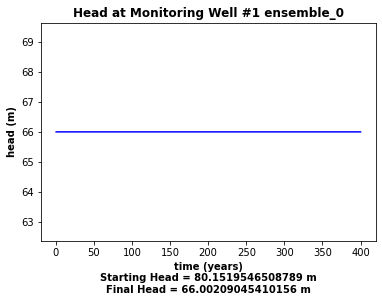

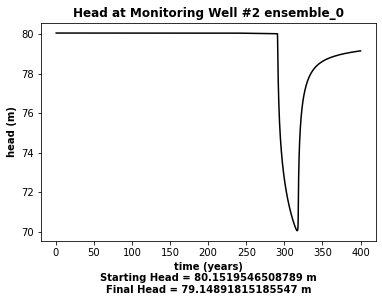

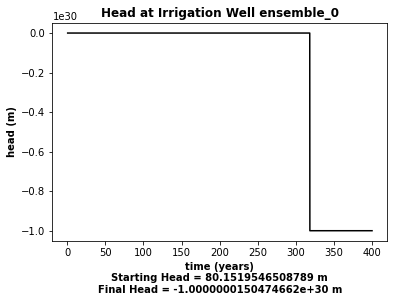

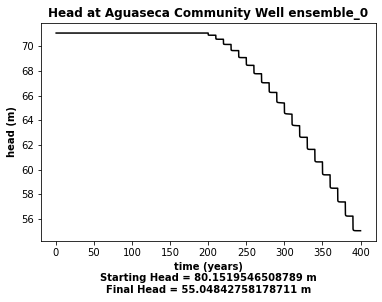

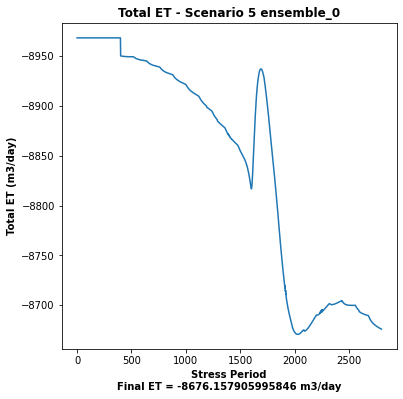

The final recharge sum for ensemble_0 is 9621.0
Total Daily flux from river to groundwater in the final year for ensemble_0 is 1200.0 m3/day


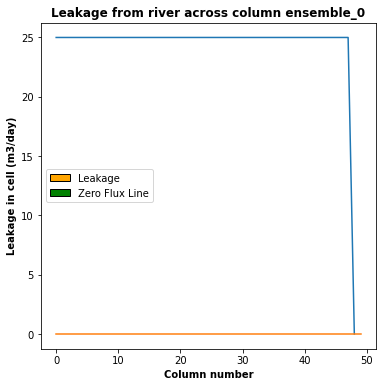

Total net Storage flux for ensemble_0 is 1377389.31 m3/day


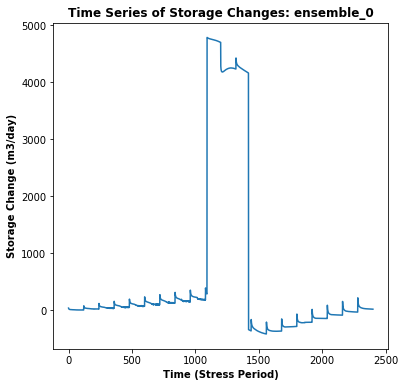

2787
Total stream leakage final year for ensemble_0 is 14400.0
2787
Total GW outflow final year for ensemble_0 is 24240.4
2787
Total ET final year for ensemble_0 is -134130.3
2787
Total Recharge outflow final year for ensemble_0 is 85440.0


TypeError: cannot pickle '_io.BufferedReader' object

In [7]:
#set up variable lists
#K upper and lower layers (isotropic) and horiz k middle layer list
k_ulm = [5,100,5,5,5,100,100,100,5,100]
#vertical K middle layer list
vka_mid = [1e-6,1e-6,1,1e-6,1e-6,1,1,1e-6,1,1]
#specific yield list 
sy = [.05,.05,.05,.05,.05,.3,.3,.3,.3,.3]
#mountain recharge list
mrr = [1e-5,1e-5,1e-5,5e-5,1e-5,5e-5,1e-5,5e-5,5e-5,5e-5]
#Valley ET rate list 
vetr = [1e-4,1e-4,1e-4,1e-4,1e-4,1e-6,1e-6,1e-6,1e-6,1e-6]
#Riparian ET rate list
retr = [3,3,3,3,3,1,1,1,1,1]
#streambed K list
streambed_k = [1e-2,1e-2,1e-2,1e-2,1,1e-2,1,1,1,1]

#loop start
# for x in range(5,10):
for x in range(10):
    modelname = "ensemble_" + str(x)
    #moddir="/Users/hardknox47/Desktop/HWRS482/MODFLOW/pymake/examples/mf2005"
    moddir="/Users/amanda_triplett/Documents/Courses/groundwater_Modeling/pymake/examples/mf2005"
    m = flopy.modflow.Modflow(modelname, exe_name = moddir)

    #Discretization - dis
    dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady, perlen=perlen, nstp=nstp)

    # Boundary and initial conditions - bas
    bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

    
    
    
    
    # setting up layer properties 
    Sy = sy[x]
    
    K_horiz = k_ulm[x] #m/d
    K_vert = k_ulm[x] #m/d
    K_vert2 = vka_mid[x] #m/d  #K for the middle layer 


    # make horizontal K np arrays
    Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
    Kh[:,:,:] = K_horiz # assign the original value to the entire array

    ## Make a arrays for the K values
    Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
    Kz[:,:,:] = K_vert                   # assign the original value to the entire array
    Kz[1,:,20:49] = K_vert2            #Replace K in the middle layer with the lower value
    Kz[1,:,:] = K_vert2
    
    #Layer properties - lpf
    lpf = flopy.modflow.ModflowLpf(m, laytyp=1, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53)
    
    
    
    
    ## ET set up
    ET = vetr[x]/2 #m/day
    ET_locxy=[[24000,0], [0, 0]] #lower left and upper right corners of ET in xy coordinate
    rip_ET= retr[x]/2  #riparian zone
    rip_locxy= [[0,21000],[23000,0]]
    extinction_depth = 10 #m

    ET_rows_forced=(1.0, 49.0) #me forcing the et_rows to be 0-50
    ET_cols_forced = (26.0, 49.0)

    ET_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
    ET_zone[0,int(ET_rows_forced[0]):int(ET_rows_forced[1]), int(ET_cols_forced[0]):int(ET_cols_forced[1])] = ET 

    rip_rows_forced = (21.0, 28.0)  #forced riparian area
    rip_cols_forced = (1.0, 49.0)


    rip_zone = np.zeros((nlay,nrow,ncol))     # define an array of zeroes the size of the model grid
    ET_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), int(rip_cols_forced[0]):int(rip_cols_forced[1])] = rip_ET 
    ET_dict={}
    for p in range(0,nper):
        ET_dict[p]=ET_zone

    #ET - evt
    evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET_dict, exdp=extinction_depth, ipakcb=53) 

    
    
    
    # Recharge - will be done in the loop
    rech= mrr[x]  #m/d
    rechxy=[(0,0),(0,36000)]  #recharge zone

    rech_rows_forced = (1.0, 49.0) #rech zone forced for leftmost 15 cols
    rech_cols_forced = (1.0, 15.0)

    agrech_rows_forced = (28.0, 30.0) #rech zone forced for leftmost 15 cols
    agrech_cols_forced = (18.0, 20.0)
    agrech = 0.00015  #pistachios (1/8th area already included)

    rech_zone_no_ag = np.zeros((1, nrow,ncol))
    rech_zone_ag = np.zeros((1, nrow,ncol))
    
    rech_zone_no_ag[0, int(rech_rows_forced[0]):int(rech_rows_forced[1]),int(rech_cols_forced[0]):int(rech_cols_forced[1])]=rech
    
    rech_zone_ag[0, int(rech_rows_forced[0]):int(rech_rows_forced[1]),int(rech_cols_forced[0]):int(rech_cols_forced[1])]=rech
    rech_zone_ag[0, int(agrech_rows_forced[0]):int(agrech_rows_forced[1]),int(agrech_cols_forced[0]):int(agrech_cols_forced[1])]=agrech
    
    
    R = {}                                             # create empty dictionary for recharge fluxes
    for p in range(0,nper):                            # loop over stress periods, skipping initial steady state defined above
        if (p < 600):
            R[p]=rech_zone_no_ag
        else:
            R[p]=rech_zone_ag


    #Recharge - rch
    rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=R, ipakcb=53)     #create rch object

    
    
    #DEFINE RIVERS
    riv_row= 24
    riv_sp = [] #create list to store all river cells for stress period 1
    k_rivbott = streambed_k[x] #river bottom hydraulic conductivity in m/d
    sed_thick = 1 #thickness of riverbed sediment in m
    cond = k_rivbott*(1)*(1000)/(sed_thick) #river bed conductance in m^2/d
    r_stage = .5 #stage in river (stress period 1)
    r_bott = ztop[riv_row,:] #river bottom
    for i in range(1,ncol):
        riv_sp.append([0, riv_row, i, r_bott[i]-1+sed_thick+r_stage, cond, r_bott[i]-2])
    
    #create dictionary of stress period data
    riv_spd = {0: riv_sp}
  
    #River - riv
    riv = flopy.modflow.ModflowRiv(model=m, stress_period_data = riv_spd, ipakcb=53)

    #Well - wel
    wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd)


    #oc package
    oc_spd = {}
    for kper in range(0, nper):
        for kstp in range(nstp[kper]):
            #print(kstp)
            oc_spd[(kper, kstp)] = ['save head','save drawdown','save budget','print head','print budget']

    oc = flopy.modflow.ModflowOc(model=m, stress_period_data=oc_spd, compact=True)

    
    #Numerical solver - pcg
    pcg = flopy.modflow.ModflowPcg(model=m, mxiter=5000, iter1=100, relax = 0.95, damp = 0.1)


    #write the inputs
    m.write_input()   
    m.check()



    #Run the model 
    success, mfoutput = m.run_model(pause=False, report=True)
    if not success:
        continue # start over on next loop if model fails to converge
    
    
    
    #Read in files from the run 
    
    hds = bf.HeadFile(modelname+'.hds')                   # reads the binary head file
    times = hds.get_times()                               # returns a list of timesteps

    #extract binary data from head file
    head = {} #create dictionary to store head data 
    frf = {} #create dictionary to store flows through right cell face 
    fff = {} #create dictionary to store flows through front cell face 
    storage = {} #create dictionary to store storage
    et = {}
    recharge = {}
    leakage_dict = {}

    headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds') #get head data as python object
    budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc') #get flow data as python object
 
#     file_name = 'head_object_'+str(modelname)+'.pickle'
#     file_name2 = 'bud_object_'+str(modelname)+'.pickle'
#     with open(file_name, 'wb') as f:
#         pickle.dump(headobj, f)
#     with open(file_name2, 'wb') as f:
#         pickle.dump(budobj, f)
    
    #get data from python objects
    for stress_per, time in enumerate(times): #iterate through times at end of each stress period
        head['sp%s'%(stress_per)] = headobj.get_data(totim=time) #append heads to head list for ea stress per
        frf['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW RIGHT FACE',totim=time) 
        fff['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW FRONT FACE',totim=time) #append front face flow to fff list for ea stress per
        #storage['sp%s'%(stress_per)] = budgobj.get_data(text='STORAGE',totim=time)
        et['sp%s'%(stress_per)] = budgobj.get_data(text='ET',totim=time)
        recharge['sp%s'%(stress_per)] = budgobj.get_data(text='RECHARGE',totim=time)
        leakage_dict['sp%s'%(stress_per)] = budgobj.get_data(text='RIVER LEAKAGE',totim=time)
    #Plot head at monitoring wells 
    #get time series for a certain cell

    cell_id1 = (0,25,24) #cell ID of MW1
    cell_id2 = (0,37,12) #cell ID of MW2
    ag_id = (0,38,12)#cell ID of ag well
    agua_id = (2,29,37) #Cell ID of aguaseca community well

    time_series1 = headobj.get_ts(cell_id1) #get the time series at MW1
    time_series2 = headobj.get_ts(cell_id2) #get the time series at MW2
    time_series_ag = headobj.get_ts(ag_id) #get the time series at ag well
    time_series_agua = headobj.get_ts(agua_id) #get the time series at agua seca com well
    
    
    #create plot of MW1
    plt.subplot(1, 1, 1)
    ax=plt.gca()
    ax.ticklabel_format(useOffset=False)
    plt.title("Head at Monitoring Well #1 " + str(modelname),fontweight='bold')
    plt.xlabel('time (years)\n'f"Starting Head = {head['sp%s'%(0)][0,38,12]} m\n"
               f"Final Head = {head['sp%s'%(len(head)-1)][0, 25, 24]} m",fontweight='bold')
    plt.ylabel('head (m)',fontweight='bold')
    plt.plot(time_series1[:, 0]/360, time_series1[:, 1], 'b-') #plot the time series with points at each record
    plt.savefig("Head_M1_"+str(modelname)+".png",dpi=600,bbox_inches='tight')
    plt.show()

    #create plot of MW2
    plt.subplot(1, 1, 1)
    ax=plt.gca()
    ax.ticklabel_format(useOffset=False)
    plt.title("Head at Monitoring Well #2 " + str(modelname),fontweight='bold')
    plt.xlabel('time (years)\n'f"Starting Head = {head['sp%s'%(0)][0,38,12]} m\n"
               f"Final Head = {head['sp%s'%(len(head)-1)][0, 37, 12]} m",fontweight='bold')
    plt.ylabel('head (m)',fontweight='bold')
    plt.plot(time_series2[:, 0]/360, time_series2[:, 1], 'k-') #plot the time series with points at each record
    plt.savefig("Head_M2_"+str(modelname)+".png",dpi=600,bbox_inches='tight')
    plt.show()

    #create plot of Ag well
    plt.subplot(1, 1, 1)
    ax=plt.gca()
    ax.ticklabel_format(useOffset=False)
    plt.title("Head at Irrigation Well " + str(modelname),fontweight='bold')
    plt.xlabel('time (years)\n'f"Starting Head = {head['sp%s'%(0)][0,38,12]} m\n"
               f"Final Head = {head['sp%s'%(len(head)-1)][0,38,12]} m",fontweight='bold')
    plt.ylabel('head (m)',fontweight='bold')
    plt.plot(time_series_ag[:, 0]/360, time_series_ag[:, 1], 'k-') #plot the time series with points at each record
    plt.savefig("Head_Ag_"+str(modelname)+".png",dpi=600,bbox_inches='tight')
    plt.show()

    #create plot of Aguaseca com well
    plt.subplot(1, 1, 1)
    ax=plt.gca()
    ax.ticklabel_format(useOffset=False)
    plt.title("Head at Aguaseca Community Well " + str(modelname),fontweight='bold')
    plt.xlabel('time (years)\n'f"Starting Head = {head['sp%s'%(0)][0,38,12]} m\n"
               f"Final Head = {head['sp%s'%(len(head)-1)][2, 29, 37]} m",fontweight='bold')
    plt.ylabel('head (m)',fontweight='bold')
    plt.plot(time_series_agua[:, 0]/360, time_series_agua[:, 1], 'k-') #plot the time series with points at each record
    plt.savefig("Head_Aqua_"+str(modelname)+".png",dpi=600,bbox_inches='tight')
    plt.show()
    
    #ET things
    ET_data = budgobj.get_data(text='ET')
    #print(np.sum(ET_data[0]))
    ET_time_series = []
    x_val = []
    for i in (range(len(ET_data))):
        test_sum = np.sum(ET_data[i])
        if test_sum == 2500:
            print("skipped")
        else:
            ET_time_series.append(test_sum)
            x_val.append(i)
#             print("attached")
            
    fig = plt.figure(figsize=(6, 6))
    plt.plot(x_val, ET_time_series)
    plt.gca().invert_yaxis()
    plt.plot()
    plt.title('Total ET - Scenario 5 '+ str(modelname),fontweight='bold')
    plt.xlabel('Stress Period\n'f"Final ET = {ET_time_series[len(ET_time_series)-1]} m3/day",fontweight='bold')
    plt.ylabel("Total ET (m3/day)", fontweight = 'bold')
    plt.savefig("ET_time_series_"+str(modelname)+".png",dpi=600,bbox_inches='tight')                   
    plt.show()
    
    #Recharge things
    Recharge_data = budgobj.get_data(text='RECHARGE')
#     for i in (range(len(Recharge_data))):
#         print("The recharge sum at ",i,'for',str(modelname),'is',np.sum(Recharge_data[i])) 
    print("The final recharge sum for",str(modelname),'is',np.sum(Recharge_data[len(Recharge_data)-1]))    
    
    #Leakage things 
    leakage = budgobj.get_data(text='RIVER LEAKAGE')
    position = len(leakage)-1
    leak=leakage[position]
    tot_leak = sum(leak.q)
    
    print("Total Daily flux from river to groundwater in the final year for",str(modelname),"is", round(tot_leak,2), "m3/day")
    
    #leakage plot
    x2 = []
    for n in range(0,50):
        x2.append(n)
    y2 = np.zeros(50)
    fig = plt.figure(figsize=(6, 6))
    x = list(range(49))
    plt.plot(x, leak.q)
    plt.plot(x2, y2)
    plt.plot()
    plt.title('Leakage from river across column '+ str(modelname),fontweight='bold')
    plt.xlabel('Column number', fontweight = 'bold')
    plt.ylabel("Leakage in cell (m3/day)", fontweight = 'bold')
    plt.legend(handles=[mp.patches.Patch(color='orange',label='Leakage',ec='black'),
                        mp.patches.Patch(color='green',label='Zero Flux Line',ec='black')])
    plt.savefig("leakage_last_year_"+str(modelname)+".png",dpi=600,bbox_inches='tight')                    
    plt.show()
    
    #Storage things 
    storage = budgobj.get_data(text='STORAGE')
    storage_series = []

    x_val_stor = []
    for x in (range(len(storage))):
        #print("The storage sum at ",x,'is',np.sum(storage[x]))
        test_sum = np.sum(storage[x])
        storage_series.append(test_sum)
        x_val_stor.append(x)
    sum_storage = sum(storage_series)
    
    print("Total net Storage flux for",str(modelname),"is", round(sum_storage,2), "m3/day")
    
    fig = plt.figure(figsize=(6, 6))
    plt.plot(x_val_stor, storage_series)
    plt.plot()
    plt.title('Time Series of Storage Changes: '+ str(modelname),fontweight='bold')
    plt.xlabel('Time (Stress Period)', fontweight = 'bold')
    plt.ylabel("Storage Change (m3/day)", fontweight = 'bold')

    plt.savefig("storage_time_series"+ str(modelname)+".png",dpi=600,bbox_inches='tight')                    
    plt.show()
    
    
    
    # Water Budget Calculation
    t2 = max(enumerate(times))
    t = t2[0] - 12
    print(t)
    leak = 0
    for i in range(12):
        leak = leak + np.sum(leakage_dict['sp%s'%(t+i)][0].q)
    print("Total stream leakage final year for",str(modelname),"is",round(leak,2))  

    ##GW outflow
    t = t2[0] - 12
    print(t)
    frf_total = 0
    for k in range(nlay):
        for i in range(12):
            frf_total = frf_total + np.sum(frf['sp%s'%(t+i)][0][k][:][48])

    print("Total GW outflow final year for",str(modelname),"is",round(frf_total,2))

    ## ET
    t = t2[0] - 12
    print(t)
    ET_total = 0
    for i in range(12):
           ET_total = ET_total + np.sum(np.sum(et['sp%s'%(t+i)][0][1][:][:]))
    print("Total ET final year for",str(modelname),"is",round(ET_total,2))

    ## Recharge
    t = t2[0] - 12
    print(t)
    rech_total = 0
    for i in range(12):
           rech_total = rech_total + np.sum(np.sum(recharge['sp%s'%(t+i)][0][1][:][:]))
    print("Total Recharge outflow final year for",str(modelname),"is",round(rech_total,2))
    
    if x == 0: 
        with open('head_obj_ens0.pickle', 'wb') as f:
            pickle.dump(headobj, f)
        with open('head_obj_ens0.pickle', 'wb') as f:
            pickle.dump(budobj, f)
    
    elif x == 1: 
        with open('head_obj_ens1.pickle', 'wb') as f:
            pickle.dump(headobj, f)
        with open('head_obj_ens1.pickle', 'wb') as f:
            pickle.dump(budobj, f)
        
    elif x == 2: 
        with open('head_obj_ens2.pickle', 'wb') as f:
            pickle.dump(headobj, f)
        with open('head_obj_ens2.pickle', 'wb') as f:
            pickle.dump(budobj, f)
        
    elif x == 3: 
        with open('head_obj_ens3.pickle', 'wb') as f:
            pickle.dump(headobj, f)
        with open('head_obj_ens3.pickle', 'wb') as f:
            pickle.dump(budobj, f)
        
    elif x == 4: 
        with open('head_obj_ens4.pickle', 'wb') as f:
            pickle.dump(headobj, f)
        with open('head_obj_ens4.pickle', 'wb') as f:
            pickle.dump(budobj, f)
        
    elif x == 5: 
        with open('head_obj_ens5.pickle', 'wb') as f:
            pickle.dump(headobj, f)
        with open('head_obj_ens5.pickle', 'wb') as f:
            pickle.dump(budobj, f)
        
    elif x == 6: 
        with open('head_obj_ens6.pickle', 'wb') as f:
            pickle.dump(headobj, f)
        with open('head_obj_ens6.pickle', 'wb') as f:
            pickle.dump(budobj, f)
        
    elif x == 7: 
        with open('head_obj_ens7.pickle', 'wb') as f:
            pickle.dump(headobj, f)
        with open('head_obj_ens7.pickle', 'wb') as f:
            pickle.dump(budobj, f)
        
    elif x == 8: 
        with open('head_obj_ens8.pickle', 'wb') as f:
            pickle.dump(headobj, f)
        with open('head_obj_ens8.pickle', 'wb') as f:
            pickle.dump(budobj, f)
        
    else: 
        with open('head_obj_ens9.pickle', 'wb') as f:
            pickle.dump(headobj, f)
        with open('head_obj_ens9.pickle', 'wb') as f:
            pickle.dump(budobj, f)
        



### Leakage calculation

In [ ]:
# well_loc
# head['sp0'][0][19][38]
# #head['sp0'][well_loc[0]][well_loc[1]][well_loc[2]]

# #budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc')
# #leakage = budgobj.get_data(text='RIVER LEAKAGE')
# #print(leakage[0])
# perflux = np.array(range(nper))

# for i in range(nper-1):
#     ##print("Stream Leakage for Stress period %s"%i)
#     perflux[i] = 0
#     for k in range(len(leakage['sp%s'%i][0])):
#         #print(leakage['sp%s'%i][0][k][1])
#         perflux[i] = perflux[i] + leakage['sp%s'%i][0][k][1]
#         #flux[i] = flux[i] + leakage[0][k][1]
    
# print(perflux)    


## Water Budget calculations

In [ ]:
# print(len(head))
# ##STream Leakage

# t2 = max(enumerate(times))
# t = t2[0] - 12
# print(t)
# leak = 0
# for i in range(12):
#     leak = leak + np.sum(leakage['sp%s'%(t+i)][0].q)
# print("Total stream leakge at year 100:")    
# print(leak)   
# # t = 0
# # ileak = 0
# # for i in range(12):
# #     ileak = ileak + np.sum(leakage['sp%s'%(t+i)][0].q)
    
# # print(int(ileak))    

# ##GW outflow
# t = t2[0] - 12
# print(t)
# frf_total = 0
# for k in range(nlay):
#     for i in range(12):
#         frf_total = frf_total + np.sum(frf['sp%s'%(t+i)][0][k][:][48])

# print("Total GW outflow 100 year:")
# print(frf_total)
# #print(np.sum(leakage['sp0'][0].q) - np.sum(leakage['sp1199'][0].q))

# ## ET
# t = t2[0] - 12
# print(t)
# ET_total = 0
# for i in range(12):
#        ET_total = ET_total + np.sum(np.sum(et['sp%s'%(t+i)][0][1][:][:]))
# print("Total ET at year 100:")
# print(ET_total) 

# ## Recharge
# t = t2[0] - 12
# print(t)
# rech_total = 0
# for i in range(12):
#        rech_total = rech_total + np.sum(np.sum(recharge['sp%s'%(t+i)][0][1][:][:]))
# print("Total rech at year 100:")
# print(rech_total)     


### Storage

In [ ]:
# # #testing things
# # type(stor)
# # stor.keys()
# # #stor.values()

# # type(stor["sp1"])
# # print(stor["sp1"])

# # SUM=(sum(stor["sp1"]))
# # print(SUM)

# # print(stor['sp1'][0][0].shape)

# # startlay0 = (stor['sp0'][0][0])
# # startlay1 = (stor['sp0'][0][1])
# # startlay2 = (stor['sp0'][0][2])
# # start_stor = startlay0 + startlay1 + startlay2
# # print(start_stor.sum())

# # endlay0 = (stor['sp1199'][0][0])
# # endlay1 = (stor['sp1199'][0][1])
# # endlay2 = (stor['sp1199'][0][2])
# # end_stor = endlay0 + endlay1 + endlay2
# # print(end_stor.sum())

# #storage change
# storage_change = 0
# for i in range(sim_years*sp_peryr*nstp[0]):
#     storage_i = stor['sp%s'%(i)][0][:].sum()
#     storage_change = storage_change + storage_i
# print(storage_change)

# #yearly storage
# yearly_stor = {}
# storage_change = 0
# yearlist = list(range(100))
# for i in range(len(yearlist)):
#     yearlist[i] = yearlist[i]*12
# #print(yearlist)

# for i in yearlist:
#     storage_change = 0
#     for sp in range(12):
#         timestep = i + sp
#         storage_i = stor['sp%s'%(timestep)][0][:].sum()
#         storage_change = storage_change + storage_i
#         #print(storage_change)
#         if sp == 11:
#             yearly_stor[i/12] = storage_change
#             print('year', i/12, storage_change)
            
            
# #more storage stuff
# storage_tot = 0
# for i in range(100):
#     storage_tot = storage_tot + yearly_stor[i]
    
# print(storage_tot)
# print(0.000810714*storage_tot)


# yearlist2 = list(range(100))
# print(yearlist2)
# print(type(yearly_stor))
# stor_ls = []
# for i in range(100):
#     stor_ls.append(yearly_stor[i])
  

In [ ]:
# plt.subplot(1, 1, 1)
# plt.title("Change in Storage",fontweight='bold')
# plt.xlabel('Year',fontweight='bold')
# plt.ylabel('Change Storage',fontweight='bold')
# plt.plot(yearlist2, stor_ls, 'b-', color="darkblue") #plot the time series with points at each record
# # plt.savefig('storage.png', dpi=600)
# plt.show()


#### Cumulative storage

In [ ]:
# cum_storage_ls = []
# cum_storage = 0
# for i in range(100):
#     cum_storage = cum_storage + yearly_stor[i]
#     cum_storage_ls.append(cum_storage)
    

In [ ]:
# plt.subplot(1, 1, 1)
# plt.title("Cumulative Change in Storage",fontweight='bold')
# plt.xlabel('Year',fontweight='bold')
# plt.ylabel('Change Storage',fontweight='bold')
# plt.plot(yearlist2, cum_storage_ls, 'b-', color="purple") #plot the time series with points at each record
# # plt.savefig('cumstorage.png', dpi=600)
# plt.show()

## Modpath

In [ ]:
# moddirmp="/Applications/MODFLOW/mp7"
# #moddirmp="/Users/abramfarley/Desktop/gw_modeling/ModFlow_Builds/pymake/examples/mp7"

# mpname=os.path.join(modelname + '_mp')

# #Set the range of cell to add particles to [layerstart, rowstart, colstart,  layerend, rowend,  colend]
# locsb = [[0, 28, 18, 0, 30, 20]]
# #locsb = [[0, 0, 0, 0, 49, 49]]
# #set the number of particles per cell
# sd = flopy.modpath.CellDataType(drape=0, columncelldivisions=2, rowcelldivisions=2, layercelldivisions=2)
# #setup theparticles
# p = flopy.modpath.LRCParticleData(subdivisiondata=[sd], lrcregions=[locsb])
# pg = flopy.modpath.ParticleGroupLRCTemplate(particlegroupname='PG1',particledata=p,filename='ex01a.pg1.sloc')
# particlegroups = [pg]

# defaultiface = {'RECHARGE': 6, 'ET': 6}

# #setup  the modpath packages
# mp = flopy.modpath.Modpath7(modelname=modelname + '_mp', flowmodel=m, exe_name=moddirmp)
# mpbas = flopy.modpath.Modpath7Bas(mp, porosity=n, defaultiface=defaultiface)
# mpsim = flopy.modpath.Modpath7Sim(mp, simulationtype='combined',
#                                   trackingdirection='forward',
#                                   weaksinkoption='stop_at',
#                                   weaksourceoption='stop_at',
#                                   budgetoutputoption='summary',
#                                   stoptimeoption='total', 
#                                   particlegroups= particlegroups)

# mp.add_package(rch) # write modpath datasets

# mp.write_input()

# # run modpath
# mp.run_model()

# mp.get_package_list()

### Read in Modpath outputs

In [ ]:
# #load in the flow path file
# fpth = os.path.join(mpname + '.mppth')
# p = flopy.utils.PathlineFile(fpth)

# #load in the end point file
# fpth = os.path.join(mpname + '.mpend')
# e = flopy.utils.EndpointFile(fpth, verbose=False)

# #make a subset which is all the particles
# pall = p.get_alldata()  #formerly pwb and ewb
# eall = e.get_alldata()

# #make a subset which is particles ending in the Aquaseca well
# nodewell = m.dis.get_node([(2, well_row, well_col)])
# print(nodewell)
# pwell1 = p.get_destination_pathline_data(dest_cells=nodewell)
# ewell1 = e.get_destination_endpoint_data(dest_cells=nodewell)

# #make a subset which is particles ending in the irrigation well
# nodewell4 = m.dis.get_node([(0, well4_row, well4_col)])
# print(nodewell4)
# pwell4 = p.get_destination_pathline_data(dest_cells=nodewell4)
# ewell4 = e.get_destination_endpoint_data(dest_cells=nodewell4)

# print(pall)

### Plotting particles

In [ ]:
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(1, 1, 1)

# ax.set_aspect('equal')
# ax.set_title('Flowlines')
# mm = flopy.plot.PlotMapView(model=m, ax=ax)
# mm.plot_grid(lw=0.5)
# mm.plot_pathline(pall, layer='all', color='blue', lw=0.5, linestyle=':', label='not captured by wells') #,marker='o', markercolor='black', markersize=3, markerevery=5)
# # mm.plot_pathline(pwell1, layer='all', color='red', lw=0.5, linestyle=':', label='Aquaseca well') # ,marker='o', markercolor='black', markersize=3, markerevery=5)
# # mm.plot_pathline(pwell4, layer='all', color='green', lw=0.5, linestyle=':', label='Irrigation well') # ,marker='o', markercolor='black', markersize=3, markerevery=5)
# # # mm.ax.legend();
# #plt.tight_layout();
# # plt.savefig('Pathlines1.png', dpi=600)